# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.xception.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.xception.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block14_sepconv2']
    LAST_LAYER = 'block14_sepconv2'
    PREPROCESSING = tf.keras.applications.xception.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.7915 - accuracy: 0.7401

947/947 [==============================] - 4919s 5s/step - loss: 0.7915 - accuracy: 0.7401 - val_loss: 0.8355 - val_accuracy: 0.7365
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.6631 - accuracy: 0.7718

947/947 [==============================] - 4661s 5s/step - loss: 0.6631 - accuracy: 0.7718 - val_loss: 0.7873 - val_accuracy: 0.7583
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6171 - accuracy: 0.7868

947/947 [==============================] - 4666s 5s/step - loss: 0.6171 - accuracy: 0.7868 - val_loss: 0.6540 - val_accuracy: 0.7765
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.7986

947/947 [==============================] - 4771s 5s/step - loss: 0.5787 - accuracy: 0.7986 - val_loss: 0.6481 - val_accuracy: 0.7796
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.5483 - accuracy: 0.8080

947/947 [==============================] - 4749s 5s/step - loss: 0.5483 - accuracy: 0.8080 - val_loss: 0.6448 - val_accuracy: 0.7847
Epoch 6/200
947/947 [==============================] - 4560s 5s/step - loss: 0.5250 - accuracy: 0.8146 - val_loss: 0.7028 - val_accuracy: 0.7640
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.8266

947/947 [==============================] - 4736s 5s/step - loss: 0.4952 - accuracy: 0.8266 - val_loss: 0.6001 - val_accuracy: 0.7955
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.8288

947/947 [==============================] - 4775s 5s/step - loss: 0.4795 - accuracy: 0.8288 - val_loss: 0.5641 - val_accuracy: 0.7995
Epoch 9/200
947/947 [==============================] - 4497s 5s/step - loss: 0.4580 - accuracy: 0.8374 - val_loss: 0.5653 - val_accuracy: 0.8050
Epoch 10/200
947/947 [==============================] - 4531s 5s/step - loss: 0.4467 - accuracy: 0.8419 - val_loss: 0.5922 - val_accuracy: 0.8076
Epoch 11/200
947/947 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.8493

947/947 [==============================] - 4898s 5s/step - loss: 0.4263 - accuracy: 0.8493 - val_loss: 0.5126 - val_accuracy: 0.8213
Epoch 12/200
947/947 [==============================] - 4567s 5s/step - loss: 0.4135 - accuracy: 0.8531 - val_loss: 0.5246 - val_accuracy: 0.8127
Epoch 13/200
947/947 [==============================] - 4589s 5s/step - loss: 0.3964 - accuracy: 0.8574 - val_loss: 0.5480 - val_accuracy: 0.8069
Epoch 14/200
947/947 [==============================] - 5073s 5s/step - loss: 0.3753 - accuracy: 0.8660 - val_loss: 0.6772 - val_accuracy: 0.7785
Epoch 15/200
947/947 [==============================] - 4471s 5s/step - loss: 0.3668 - accuracy: 0.8687 - val_loss: 0.5571 - val_accuracy: 0.8103
Epoch 16/200
947/947 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.8738

947/947 [==============================] - 4760s 5s/step - loss: 0.3525 - accuracy: 0.8738 - val_loss: 0.5053 - val_accuracy: 0.8305
Epoch 17/200
947/947 [==============================] - 4580s 5s/step - loss: 0.3347 - accuracy: 0.8795 - val_loss: 0.6667 - val_accuracy: 0.7769
Epoch 18/200
947/947 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8809

947/947 [==============================] - 4761s 5s/step - loss: 0.3299 - accuracy: 0.8809 - val_loss: 0.4997 - val_accuracy: 0.8370
Epoch 19/200
947/947 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.8885

947/947 [==============================] - 4737s 5s/step - loss: 0.3146 - accuracy: 0.8885 - val_loss: 0.4946 - val_accuracy: 0.8278
Epoch 20/200
947/947 [==============================] - 4470s 5s/step - loss: 0.3036 - accuracy: 0.8918 - val_loss: 0.5745 - val_accuracy: 0.8078
Epoch 21/200
947/947 [==============================] - 4693s 5s/step - loss: 0.2957 - accuracy: 0.8937 - val_loss: 0.5904 - val_accuracy: 0.7961
Epoch 22/200
947/947 [==============================] - ETA: 0s - loss: 0.2778 - accuracy: 0.8992

947/947 [==============================] - 4796s 5s/step - loss: 0.2778 - accuracy: 0.8992 - val_loss: 0.4871 - val_accuracy: 0.8394
Epoch 23/200
947/947 [==============================] - 4734s 5s/step - loss: 0.2662 - accuracy: 0.9031 - val_loss: 0.5111 - val_accuracy: 0.8321
Epoch 24/200
947/947 [==============================] - 4598s 5s/step - loss: 0.2579 - accuracy: 0.9066 - val_loss: 0.4911 - val_accuracy: 0.8367
Epoch 25/200
947/947 [==============================] - 5297s 6s/step - loss: 0.2449 - accuracy: 0.9126 - val_loss: 0.5121 - val_accuracy: 0.8325
Epoch 26/200
947/947 [==============================] - 8866s 9s/step - loss: 0.2399 - accuracy: 0.9137 - val_loss: 0.7174 - val_accuracy: 0.8029
Epoch 27/200
947/947 [==============================] - 8046s 8s/step - loss: 0.2284 - accuracy: 0.9182 - val_loss: 0.4877 - val_accuracy: 0.8501
Epoch 28/200
947/947 [==============================] - 6877s 7s/step - loss: 0.2144 - accuracy: 0.9228 - val_loss: 0.6014 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 451s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9679943057911315,
 'basal cell carcinoma': 0.9795810729355034,
 'dermatofibroma': 0.9660889481420709,
 'melanoma': 0.9348986295819285,
 'nevus': 0.9658351569099527,
 'pigmented benign keratosis': 0.9827679938944386,
 'seborrheic keratosis': 0.9642337599815805,
 'solar lentigo': 0.9677040938472588,
 'squamous cell carcinoma': 0.9779876857124845,
 'vascular lesion': 0.9992940154230476}

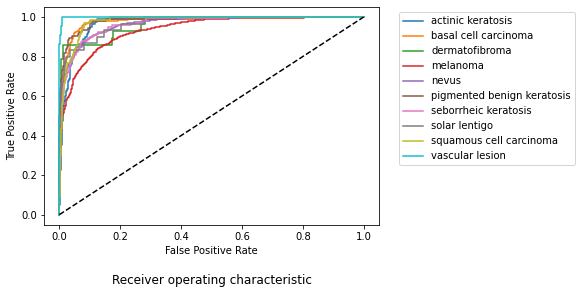

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

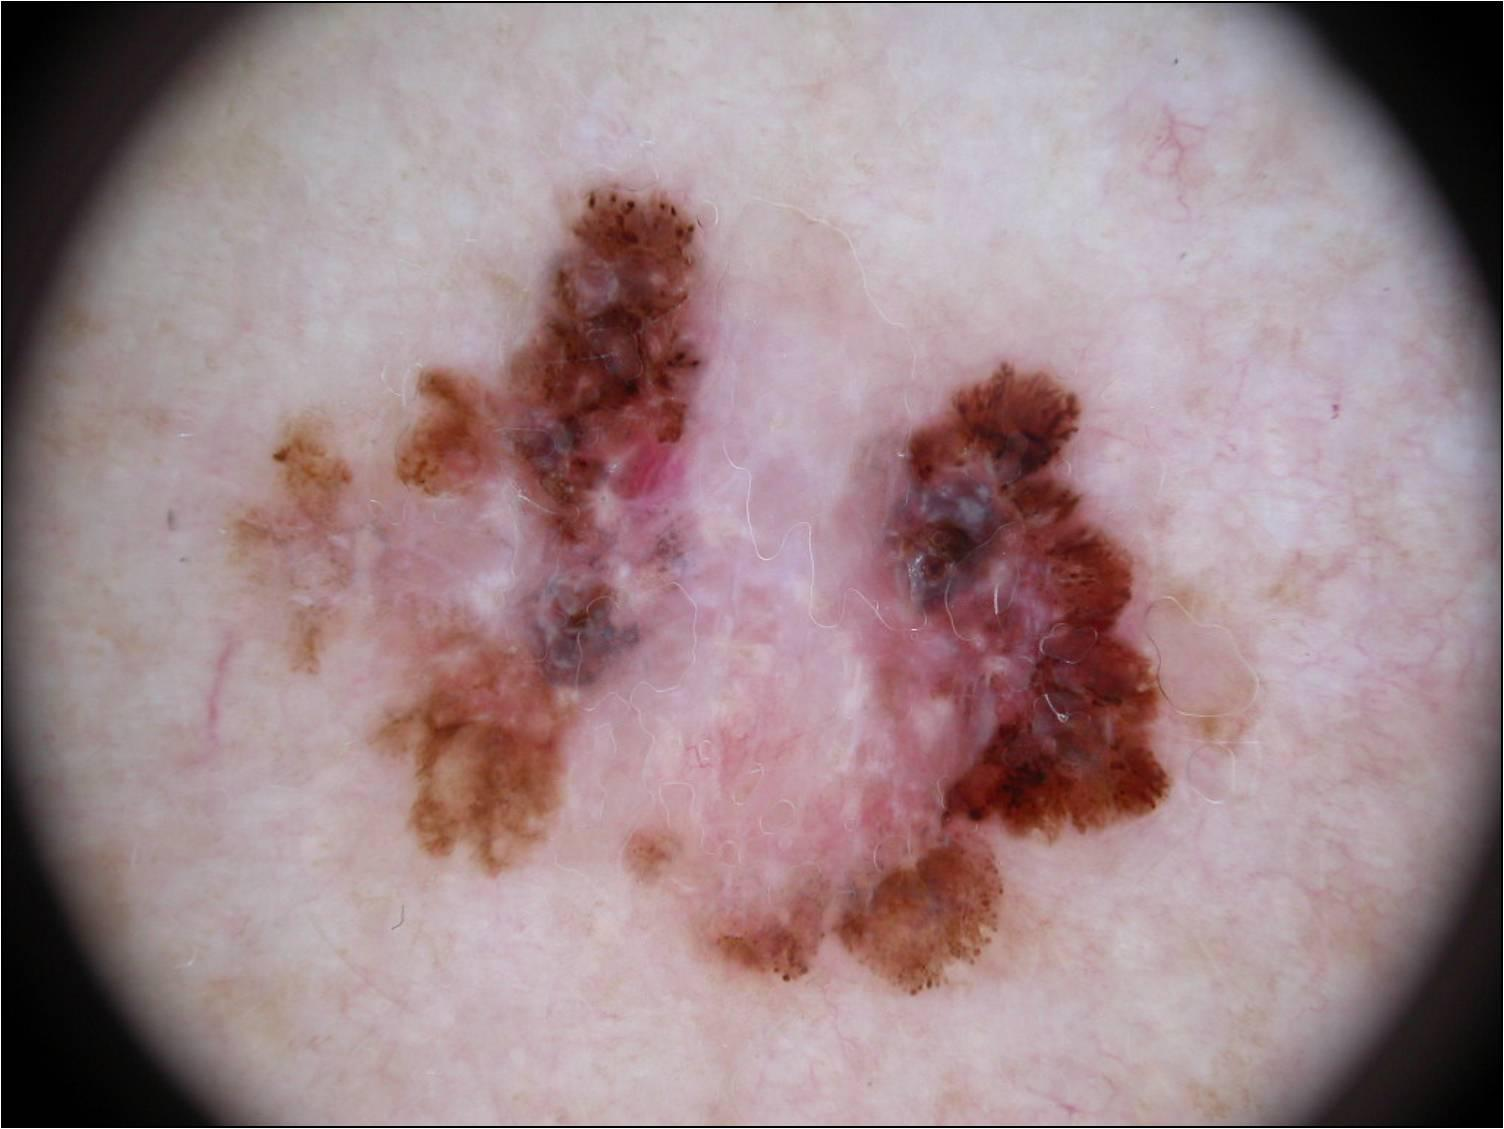

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

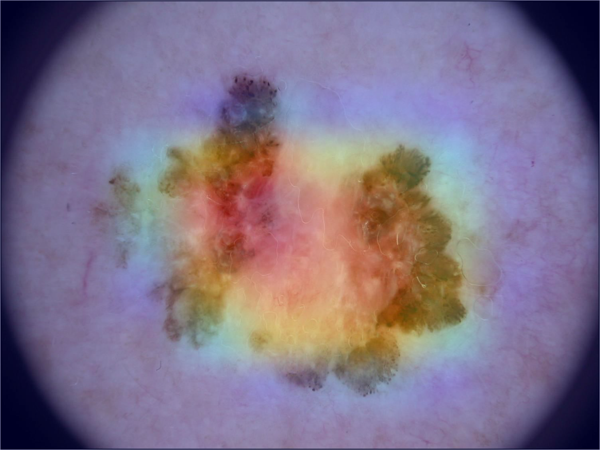

In [23]:
display_gradcam(melanoma_im_path, heatmap)